In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cryptocurrency-price-direction-predictor/sample_submission.csv
/kaggle/input/cryptocurrency-price-direction-predictor/train.csv
/kaggle/input/cryptocurrency-price-direction-predictor/test.csv


We are having 2 csv files- train.csv(2.1 million rows) and test.csv(~1million rows).

**Approach**

1. Data Exploration and EDA. Data Transformation

2. Checking if data is stationary or not using ADFuller, ACF and PACF. If not will use differencing, np.log and create other features with high importance.

3. In this notebook we will implement Decision Tree, Logistic Regression, Random Forest, XGBooost and Long Short Term Memory(LSTM- Neural Network) models.

4. We will see which baseline algorithm is giving high accuracy. And then we will do hyper parameter tuning using GridSearchCV and perform Feature Engineering by adding or removing features.


In [2]:
#We will load rest of the library according to our need along with the code.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# EDA

In [3]:
#Loading the data
train_ori=pd.read_csv('/kaggle/input/cryptocurrency-price-direction-predictor/train.csv')
test_ori=pd.read_csv('/kaggle/input/cryptocurrency-price-direction-predictor/test.csv')

In [4]:
test_ori.head(2)

,row_id,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume
0,0,1652817480,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237
1,1,1652817540,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312


In [5]:
train_ori.head(2)

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0


In [6]:
print("Train data shape",train_ori.shape)
print("Test data shape",test_ori.shape)

Train data shape (2122438, 11)
Test data shape (909617, 11)


In [7]:
train_ori.dtypes

timestamp                   int64
open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
quote_asset_volume        float64
number_of_trades          float64
taker_buy_base_volume     float64
taker_buy_quote_volume    float64
target                    float64
dtype: object

In [8]:
#We need to convert timestamp to standard format, as currently it is UNIX format
train_ori['timestamp']=pd.to_datetime(train_ori['timestamp'], unit='s')
test_ori['timestamp']=pd.to_datetime(test_ori['timestamp'], unit='s')

In [9]:
#Duration of Training data
start=train_ori.iloc[0].timestamp
end=train_ori.iloc[-1].timestamp
print(f"Data from {start} to {end}")

Data from 2018-05-04 22:01:00 to 2022-05-17 19:58:00


In [10]:
#Duration of Testing data
start=test_ori.iloc[0].timestamp
end=test_ori.iloc[-1].timestamp
print(f"Data from {start} to {end}")

Data from 2022-05-17 19:58:00 to 2024-02-08 12:14:00


**We have training data from- May-2018 to May-2022
and Testing data from- May-2022 to Feb-2024**

**Checking Missing Timestamps**

In [11]:
def missing_timestamp(train_ori):
    time_diff=train_ori.timestamp[1:]-train_ori.timestamp[:-1]
    count= time_diff.value_counts()
    return count.head()

In [12]:
missing_timestamp(train_ori)

timestamp
0 days    2122436
Name: count, dtype: int64

**We have no missing timestamps**

**Visualizing correlation between features**

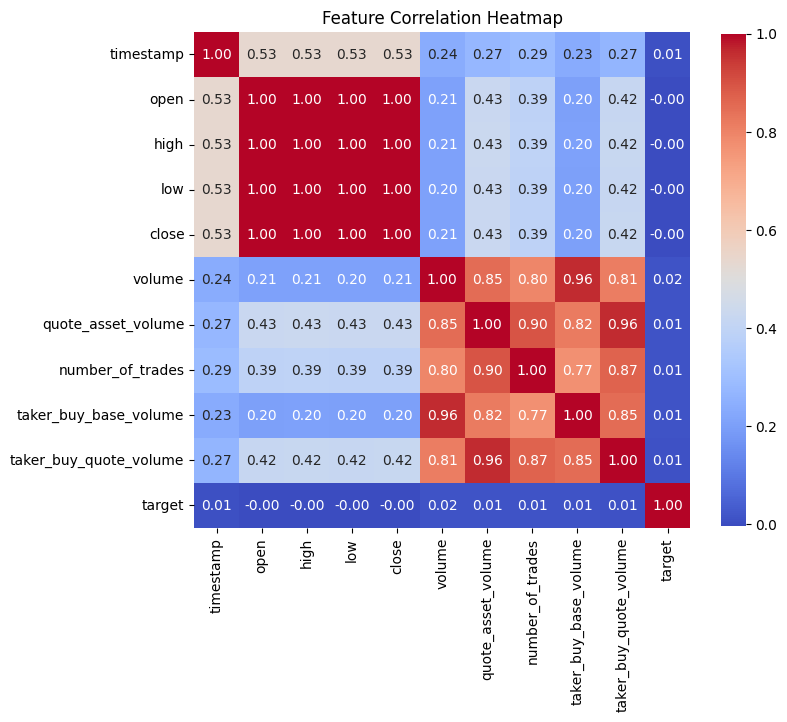

In [13]:
correlation_matrix = train_ori.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap')
plt.show()

**There is strong correlation between- Open, close, High and Low. We will also try to use other Volume related features to see if they are increaing the accuracy**

# Is Data Stationary?

**Next thing we have to check if the data is normally distibuted or not. because it will impact model performance.**

In [14]:
#Creating a copy of train_ori with few data points
train=train_ori[:100000]
test=test_ori

train.loc[:,'target'] = (train['close'].shift(-1) > train['close']).astype(int)
#deleting the last row, because its null
train_data = train[:-1].copy()
test_data=test.copy()
train_data.set_index('timestamp', inplace=True)
test_data.set_index('timestamp', inplace=True)

<Axes: xlabel='timestamp'>

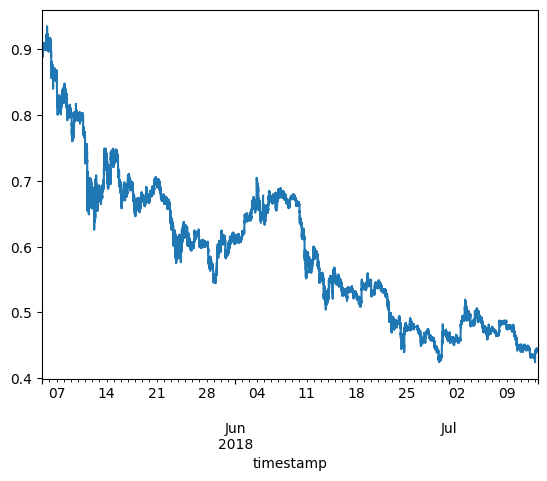

In [15]:
train_data['close'].plot()

**We can see in the above chart that data is not stationary with time.**

<Axes: xlabel='timestamp'>

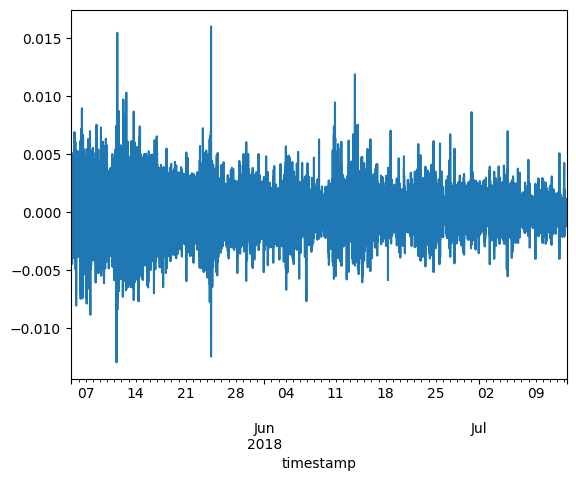

In [16]:
#Creating Differencing
train_data['close_diff'] = train_data['close'].diff().fillna(0) 
train_data['close_diff'].plot()

**Differencing the data makes the data stationary**

**Checking through ADF and PCF plots**

**In ADF if p <.05 then we fail to reject null hypothesis. means data is non stationary. To solve this we will perform few transformations, such as log transform, SMA, MA, EMA diff etc**

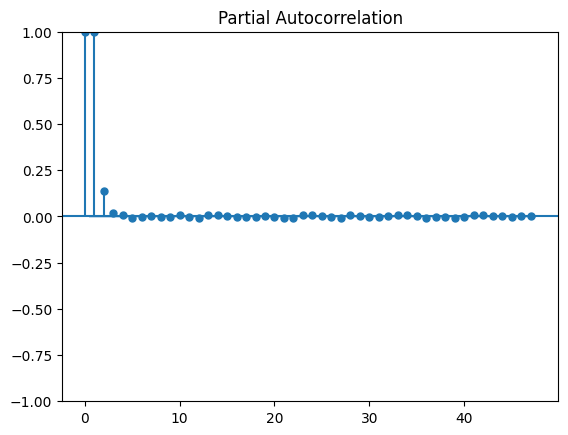

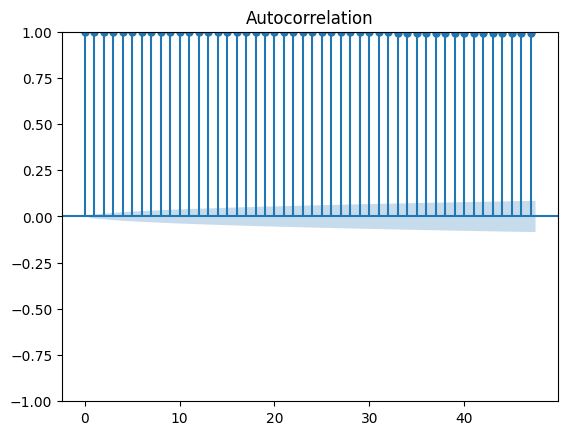

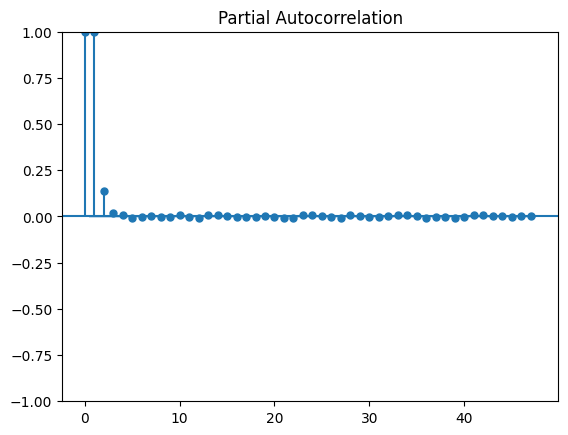

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data['close'].iloc[:50000])
plot_pacf(train_data['close'].iloc[:50000])


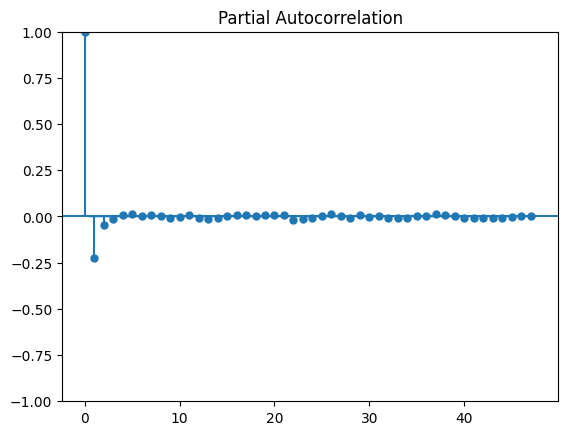

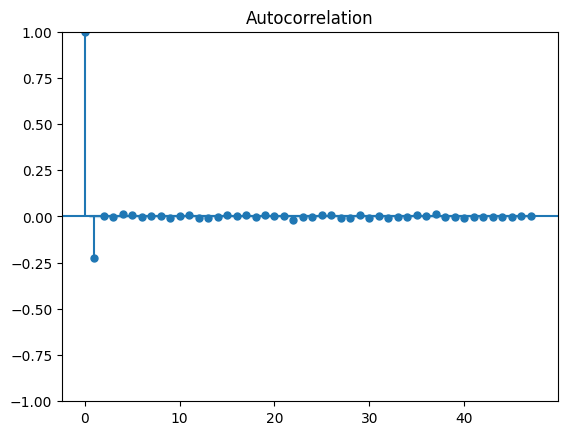

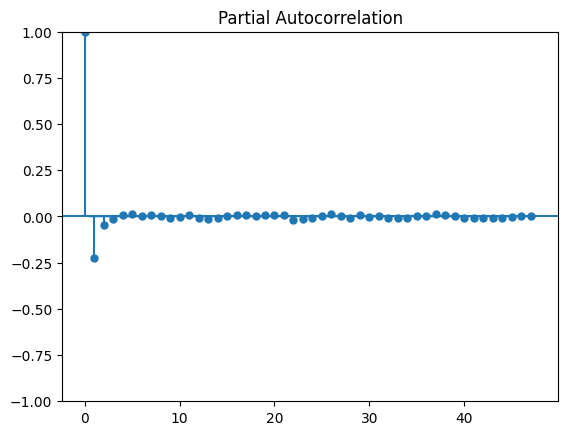

In [18]:
plot_acf(train_data['close_diff'].iloc[:50000])
plot_pacf(train_data['close_diff'].iloc[:50000])

In [19]:
from statsmodels.tsa.stattools import adfuller

adftest_before=adfuller(train_data['close'].iloc[:50000])
adftest_after=adfuller(train_data['close_diff'].iloc[:50000])
print(f'before differencing p value- {adftest_before[1]}')
print(f'after differencing p value- {adftest_after[1]}')     

before differencing p value- 0.09380940960466094
after differencing p value- 0.0


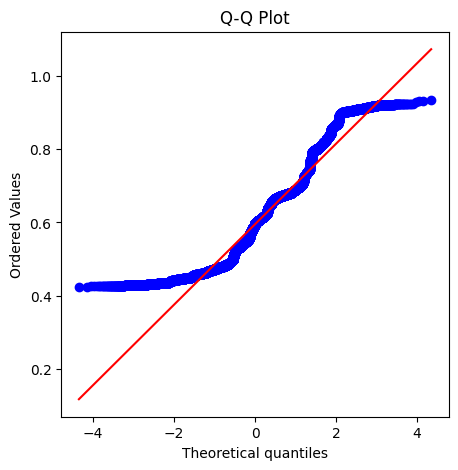

In [20]:
import scipy.stats as stats

plt.figure(figsize=(5, 5))
stats.probplot(train_data['close'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

**Normalized data should less deviate from the straight line.**

**Checking Patterns and Seasonality**

<Axes: xlabel='timestamp'>

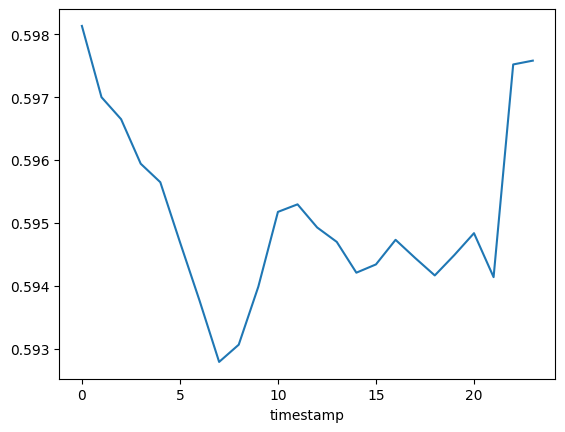

In [21]:
train_data.groupby(train_data.index.hour)['close'].mean().plot()

**Data is deviating from straight line- means its not normally distd. Lets check histogram with kde for better understanding.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


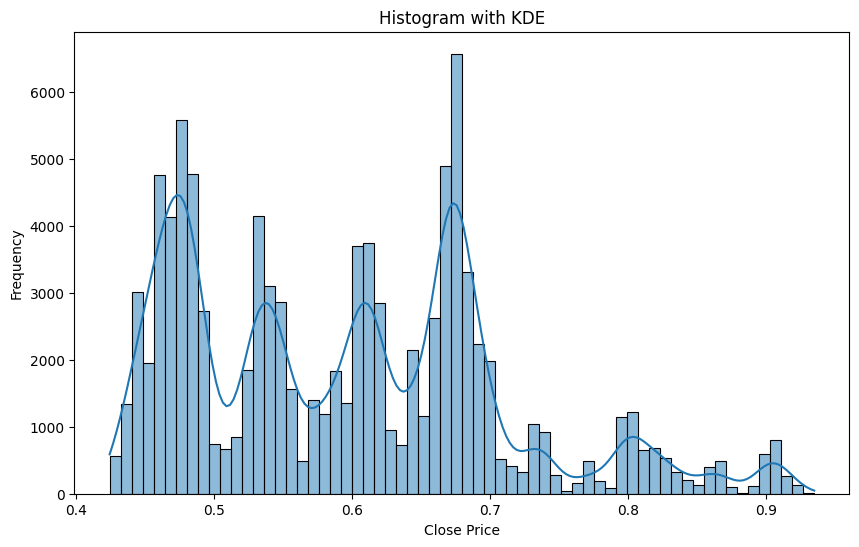

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['close'], kde=True)
plt.title('Histogram with KDE')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

**Clearly Data is right skeweed and not distributed normally. We can either resample the data or perform transformation such as log, sqrt, diff, rolling mean.That will be done in later section.**

# Feature Engineering

In [23]:
from datetime import datetime

In [24]:
#Loading libraries we will need to train models
from sklearn.model_selection import train_test_split

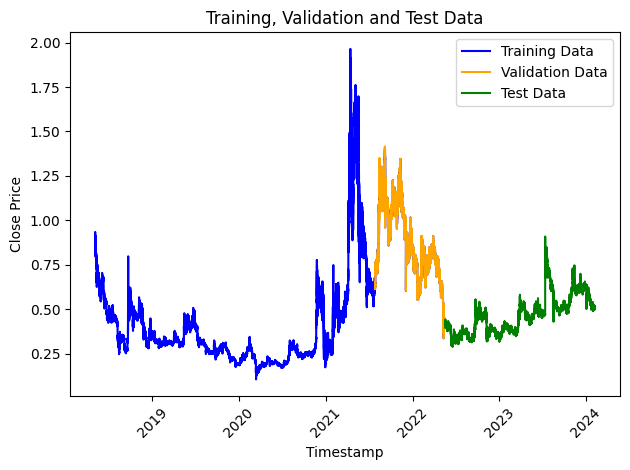

In [25]:
features = ['open', 'high', 'low', 'close', 'volume']
features_col=train_ori.drop(columns=['target']).columns
X_train = train_ori[features]
y_train = train_ori['target']

#Train-Test Split for Validation, We are using 80% as training and 20% as validation data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, 
                                            test_size=0.2, shuffle=False)
# Plot Training Data
plt.plot(train_ori['timestamp'], train_ori['close'], label='Training Data', color='blue')

# Plot Validation Data (last part of training data used as validation)
plt.plot(train_ori['timestamp'][len(train_ori) - len(y_val_split):], 
         train_ori['close'][len(train_ori) - len(y_val_split):], 
         label='Validation Data', color='orange')

# Plot Test Data
plt.plot(test_ori['timestamp'], test_ori['close'], label='Test Data', color='green')

plt.title('Training, Validation and Test Data')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**We can see that this a good train-test split, Our model will be trained on both Low data points as well as High data points. So it can predict pretty well in either case.**

In [26]:
train=train_ori[:200000]
test=test_ori

In [27]:
#Target logic- If tommorow close > today close, mark 1 else 0
train.loc[:,'target'] = (train['close'].shift(-1) > train['close']).astype(int)

In [28]:
#deleting the last row, because its null
train_data = train[:-1].copy()
test_data=test_ori.copy()

In [29]:
train_data.set_index('timestamp', inplace=True)
test_data.set_index('timestamp', inplace=True)

In [30]:
# Extract useful time features from 'timestamp'
train_data.loc[:, 'hour'] = train_data.index.hour
train_data.loc[:, 'minute'] = train_data.index.minute
train_data.loc[:, 'dayofweek'] = train_data.index.dayofweek
train_data.loc[:, 'day'] = train_data.index.day
train_data.loc[:, 'month'] = train_data.index.month

test_data['hour'] = test_data.index.hour
test_data['minute'] = test_data.index.minute
test_data['dayofweek'] = test_data.index.dayofweek
test_data['day'] = test_data.index.day
test_data['month'] = test_data.index.month

**Creating Rolling mean, Rolling Standard Deviation, and EMA**

In [31]:
def create_features(df):

    df['tbvolume_60'] = df['taker_buy_base_volume'].diff(2).fillna(0)
    df['tbvolume'] = df['taker_buy_quote_volume'].diff(5).fillna(0)    
    df['pct_change_close'] = df['close'].pct_change().fillna(0)
    df['pct_change_open'] = df['open'].pct_change().fillna(0)
    df['pct_change_high'] = df['high'].pct_change().fillna(0)
    df['pct_change_low'] = df['low'].pct_change().fillna(0)
    
    
    df['close_diff'] = df['close'].diff(2).fillna(0) 
    df['open_diff'] = df['open'].diff(2).fillna(0)
    
    df['close_std'] = df['close'].rolling(window=10).std().fillna(0)
    df['open_std'] = df['open'].rolling(window=10).std().fillna(0)
    df['close_std_60'] = df['close'].rolling(window=5).std().fillna(0)
    df['momentum_c'] = (df['close_diff'] - df['close_diff'].shift(60)).fillna(0)
    df['momentum_o'] = (df['open_diff'] - df['open_diff'].shift(60)).fillna(0)
    
    df['close_diff_lag_1'] = df['close_diff'].shift(7).fillna(0)
    df['close_diff_lag_2'] = df['close_diff'].shift(14).fillna(0)
    df['close_diff_lag_3'] = df['close_diff'].shift(21).fillna(0)
    
    df['open_diff_lag_1'] = df['open_diff'].shift(7).fillna(0)
    df['open_diff_lag_2'] = df['open_diff'].shift(14).fillna(0)
    df['open_diff_lag_3'] = df['open_diff'].shift(21).fillna(0)
    df['vol_diff_lag_3'] = df['volume'].shift(2).fillna(0)
    
    delta_test = df['open'].diff(2).fillna(0)
    gain_test = (delta_test.where(delta_test > 0, 0)).rolling(window=10).mean().fillna(0)
    loss_test = (-delta_test.where(delta_test < 0, 0)).rolling(window=10).mean().fillna(0)
    rs_test = gain_test / loss_test
    df['rsi_open'] = 100 - (100 / (1 + rs_test)).fillna(0)
    
    return df

In [32]:
train_data = create_features(train_data)
test_data = create_features(test_data)

# ARIMA Model

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [34]:
train_series = train_data['close_diff']

In [35]:
train_size = int(len(train_series) * 0.8)
train, valid = train_series[:train_size], train_series[train_size:]

In [36]:
arima_model = ARIMA(train, order=(0, 1, 3))  # (p, d, q) values can be tuned further
arima_fitted = arima_model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


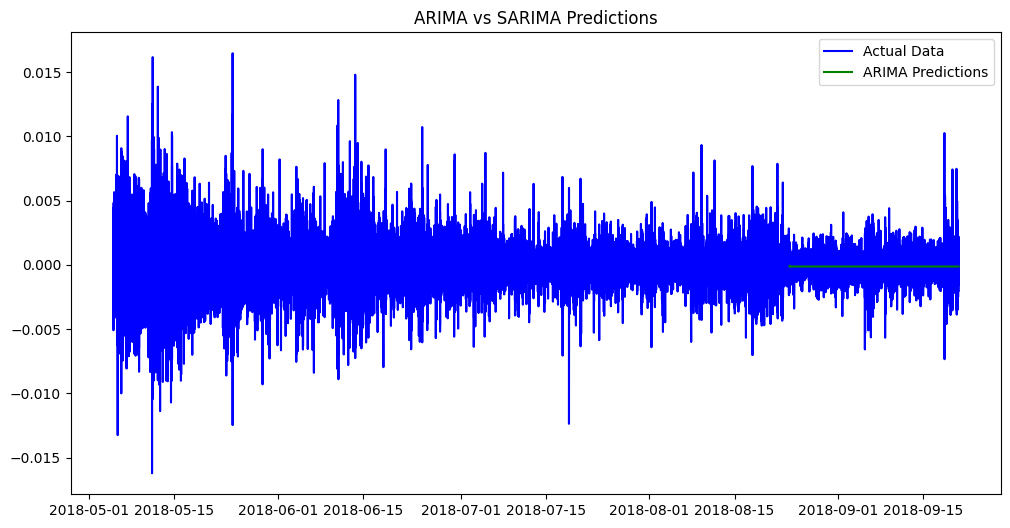

In [37]:
arima_pred = arima_fitted.predict(start=train_size, end=len(train_series)-1, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Actual Data', color='blue')
plt.plot(valid.index, arima_pred, label='ARIMA Predictions', color='green')
plt.legend()
plt.title('ARIMA vs SARIMA Predictions')
plt.show()

**Commenting ARIMA Model beacuse I've tried it and it gives the 48% Accuracy**

In [38]:
'''test2_length = len(test_data)

# Forecast with ARIMA model
arima_forecast = arima_fitted.forecast(steps=test2_length)

# Add the forecasts to the test2 dataframe for comparison
test_data['ARIMA_Predicted_Close'] = arima_forecast.values

'''

"test2_length = len(test_data)\n\n# Forecast with ARIMA model\narima_forecast = arima_fitted.forecast(steps=test2_length)\n\n# Add the forecasts to the test2 dataframe for comparison\ntest_data['ARIMA_Predicted_Close'] = arima_forecast.values\n\n"

In [39]:
'''test_data['target']= (test_data['ARIMA_Predicted_Close'] > test_data['close'], 1,0).astype(int)
output=test_data[['row_id', 'target']]
output.to_csv('submission.csv', index=False)'''

"test_data['target']= (test_data['ARIMA_Predicted_Close'] > test_data['close'], 1,0).astype(int)\noutput=test_data[['row_id', 'target']]\noutput.to_csv('submission.csv', index=False)"

# Training Models

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

In [41]:
#Creating Feature list
features_col=['month', 'pct_change_close', 'pct_change_high', 'pct_change_low',
       'close_diff', 'close_std', 'close_std_60', 'rsi_open']

features=train_data.drop(columns=['target','open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume',
        'hour', 'minute', 'dayofweek']).columns

X = train_data[features]
y = train_data['target']
#Train-Test Split for Validation, We are using 80% as training and 20% as validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                            test_size=0.2, shuffle=False)

In [42]:
#standardization of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(test_data[features_col])
                                 
X_test_scaled = scaler.transform(test_data.drop(columns=['row_id','open','high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume',
        'hour', 'minute', 'dayofweek']))

In [43]:
#Creating list of Models with parameters
models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.2, max_depth=6),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=30, max_depth=10,criterion='entropy'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    
}

In [44]:
# Train, Predict, and Evaluate Models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)

    # Macro-Averaged F1 Score
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    print(f"{model_name} Macro-Averaged F1 Score: {f1_macro:.4f}")
    print(classification_report(y_val, y_val_pred))

Training XGBoost...
XGBoost Macro-Averaged F1 Score: 0.5815
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65     21547
         1.0       0.57      0.46      0.51     18453

    accuracy                           0.59     40000
   macro avg       0.59      0.58      0.58     40000
weighted avg       0.59      0.59      0.59     40000

Training Decision Tree...
Decision Tree Macro-Averaged F1 Score: 0.5242
              precision    recall  f1-score   support

         0.0       0.56      0.56      0.56     21547
         1.0       0.49      0.49      0.49     18453

    accuracy                           0.53     40000
   macro avg       0.52      0.52      0.52     40000
weighted avg       0.53      0.53      0.53     40000

Training Random Forest...
Random Forest Macro-Averaged F1 Score: 0.5584
              precision    recall  f1-score   support

         0.0       0.59      0.79      0.67     21547
         1.0       0.59      0.35

In [45]:
#Predictions for test set using the best model
best_model = models['Logistic Regression']
y_test_pred = best_model.predict(X_test_scaled)

#Saving in csv
output = pd.DataFrame({
    'row_id': test_data['row_id'], 
    'target': y_test_pred
})

output.to_csv('submission.csv', index=False)

# Feature Importance

In [46]:
model=DecisionTreeClassifier()
#model=xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = model.feature_importances_

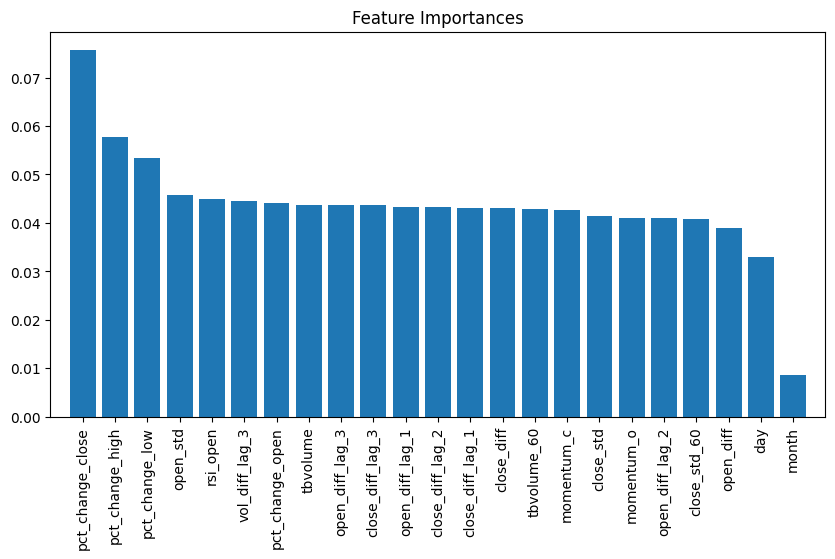

In [47]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

**Important Feature using LASSO**

In [48]:
# Fit Lasso regression
lasso = Lasso(alpha=0.01)  # Adjust alpha as needed
lasso.fit(X_train_scaled, y_train)

# Check the coefficients
print("Lasso Coefficients:", lasso.coef_)

# Select features with non-zero coefficients
selected_features = X_train.columns[lasso.coef_ != 0]
print("Selected Features by Lasso:", selected_features)

Lasso Coefficients: [ 0.          0.00442043  0.          0.         -0.06481458  0.
  0.01637328  0.01420352 -0.0232762   0.          0.00408317  0.
  0.00197491 -0.          0.         -0.          0.         -0.
 -0.          0.         -0.          0.          0.01410403]
Selected Features by Lasso: Index(['month', 'pct_change_close', 'pct_change_high', 'pct_change_low',
       'close_diff', 'close_std', 'close_std_60', 'rsi_open'],
      dtype='object')


# LSTM Modelling

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [50]:
# Reshape data for LSTM (samples, time steps, features)
X_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [51]:
# Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
# Compile the LSTM Model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM Model
lstm_model.fit(X_lstm[:len(y_train)], y_train.values, epochs=25, batch_size=32)

Epoch 1/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.5939 - loss: 0.6660
Epoch 2/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6153 - loss: 0.6538
Epoch 3/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6190 - loss: 0.6515
Epoch 4/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6200 - loss: 0.6500
Epoch 5/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6213 - loss: 0.6496
Epoch 6/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6228 - loss: 0.6479
Epoch 7/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6278 - loss: 0.6454
Epoch 8/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6257 - loss: 0.6449
Epoch 9/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6260 - loss: 0.6443
Epoch 10/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6302 - loss: 0.6422
Epoch 11/25
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6283 - loss: 0.6421
Epoch 12/25
5000/50

In [53]:
y_test_pred_lstm = (lstm_model.predict(X_lstm) > 0.7).astype(int)

# Print predictions for test data from LSTM
print("Predicted values from LSTM on test data:")
print(y_test_pred_lstm.flatten())

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Predicted values from LSTM on test data:
[0 0 0 ... 0 0 0]


In [54]:
#submission_lstm = pd.DataFrame({'row_id': test_data['row_id'], 'target': y_test_pred_lstm.flatten()})
#submission_lstm.to_csv('submission_lstm.csv', index=False)

# Hyperparameter Tuning

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [56]:
# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [20,40, 60],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [57]:
''''rf_model=RandomForestClassifier()
#Random Forest grid search
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='accuracy', cv=5)
rf_grid_search.fit(X_train_scaled, y_train)'''

"'rf_model=RandomForestClassifier()\n#Random Forest grid search\nrf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='accuracy', cv=5)\nrf_grid_search.fit(X_train_scaled, y_train)"

In [58]:
'''# Best parameters and estimator from grid search for Random Forest

best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

print(f"Best parameters for Random Forest: {best_rf_params}")
'''

'# Best parameters and estimator from grid search for Random Forest\n\nbest_rf_params = rf_grid_search.best_params_\nbest_rf_model = rf_grid_search.best_estimator_\n\nprint(f"Best parameters for Random Forest: {best_rf_params}")\n'

In [59]:
'''# Validate the best Random Forest Model
y_val_pred_rf = best_rf_model.predict(X_val_scaled)
rf_accuracy = accuracy_score(y_val_split, y_val_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
'''

"# Validate the best Random Forest Model\ny_val_pred_rf = best_rf_model.predict(X_val_scaled)\nrf_accuracy = accuracy_score(y_val_split, y_val_pred_rf)\nprint(f'Random Forest Accuracy: {rf_accuracy:.4f}')\n"

In [60]:
# Step 8: Prepare Test Data for Predictions using all models (including tuned models)

#X_test = test_data[features]
#X_test_scaled = scaler.transform(X_test)  # Scale test data using the same scaler

# Make predictions on test data using the tuned models
#y_test_pred_rf = best_rf_model.predict(X_test_scaled)
#print("\nPredicted values from Tuned Random Forest on test data:")
#print(y_test_pred_rf)



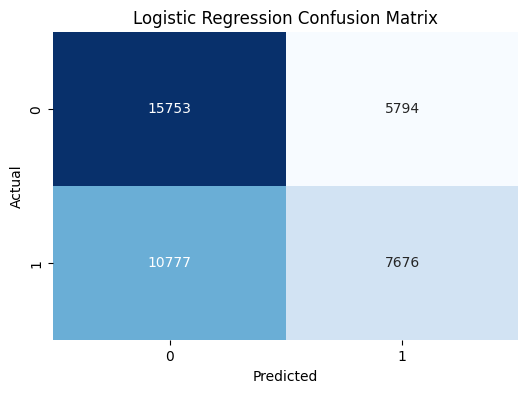

In [61]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"{model_name} Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()